
Data Mining - MSDS 7331 - Thurs 6:30, Summer 2016

Team 3 (AKA Team Super Awesome):  Sal Melendez, Rahn Lieberman, Thomas Rogers

Github page:
https://github.com/RahnL/DataScience-SMU/tree/master/DataMining

Note: Code borrowed heavily from Eric Larson's github pages for this class.
https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb

Code also borrowed from other projects we're working on using the same dataset.

https://github.com/RahnL/DataScience-SMU/blob/master/DataMining/DataMining-MiniLab1-Lieberman-Melendez-Rogers.ipynb
https://github.com/rlshuhart/MSDS6210-Immersion_Project/blob/master/Study/Closing%20the%20Gap%20Study%20Revisited.ipynb


## Contents
* Intro
* Data Cleanup and Reduction

**Classifications:**
* Logistical Regression
* K-Nearest Neighbor, with and without PCA
* Random Forest
* Gradient Boosting Regression

## Data Preparation


Our team has selected the 2014 Behavioral Risk Factor Surveillance System data (BRFSS), from the Center for Disease Control and prevention (CDC), to attempt to understand the relationship between quality of health and a number of behavioral, demographic and environmental factors. 

The purpose of the BRFSS project is to survey a large population of Americans on a wide range of topics to inform policy, research and healthcare delivery. The same or similar questions are asked each year and the resulting dataset gives not only a broad, comprehensive view of health quality in the United States, but it also provides a longitudinal view on how quality of care (among other factors) is changing over time.

There are 279 variables in the dataset and over 460,000 surveys completed. The sheer breadth and complexity of this data, with missing, weighted and calculated variables requires a clear and distinct question of interest and some sense of what variables might help answer the question. We have chosen to focus on one particular question in the survey as our response variable and will attempt to better understand the impact reported behaviors have on responses to that question. 

Our response variable becomes the answer to the following question on quality of health: "Would you say that in general your health is: (1) excellent, (2) very good, (3) good, (4) fair, (5) poor?" (section 1.1, column 80)

We reduce the 279 variables to focus on those related to behavioral survey questions. The corresponding variables from the questions related to behavior number 30, so our dataset is roughly 450,000 rows by 30 columns. 

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

# plot graphs in the notebook
%matplotlib inline

In [2]:
# Read the dataset, and do some initial cleanup.

df = pd.read_csv("data/LLCP2014XPT.txt", sep="\t", encoding = "ISO-8859-1")
df.head()

print("Starting length is %.f " % len(df))

df.info()
df.head()

C:\Users\trogers\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Starting length is 464664 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464664 entries, 0 to 464663
Columns: 279 entries, _STATE to RCSBIRTH
dtypes: float64(226), int64(52), object(1)
memory usage: 989.1+ MB


,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_FOBTFS,_CRCREC,_AIDTST3,_IMPEDUC,_IMPMRTL,_IMPHOME,RCSBRAC1,RCSRACE1,RCHISLA1,RCSBIRTH
0,1,1,1172014,1,17,2014,1100,2014000001,2014000001,1.0,...,2.0,1.0,2.0,5,1,1,NaN,NaN,NaN,NaN
1,1,1,1072014,1,7,2014,1100,2014000002,2014000002,1.0,...,2.0,2.0,2.0,4,1,1,NaN,NaN,NaN,NaN
2,1,1,1092014,1,9,2014,1100,2014000003,2014000003,1.0,...,2.0,2.0,2.0,6,1,1,NaN,NaN,NaN,NaN
3,1,1,1072014,1,7,2014,1100,2014000004,2014000004,1.0,...,2.0,1.0,2.0,6,3,1,NaN,NaN,NaN,NaN
4,1,1,1162014,1,16,2014,1100,2014000005,2014000005,1.0,...,2.0,1.0,2.0,5,1,1,NaN,NaN,NaN,NaN


## Data Reduction and Pre-processing

We're interested in the relationship between behaviors, demographics and other factors, and the impact they have on general health quality. For this reason, we'll narrow down the dataset to those variables that we believe are most pertinent. Smoking and the level of physical activity have a demonstrated impact on health quality and they’re behaviors. Age has an obvious impact, but education, income level and race may have a less obvious impact. The cost and access to care have been identified as factors that negatively impact health, so we’ll include those as well. Our model ultimately will show the relative impact these variables have on health quality. 

#### Behaviors:
- Whether someone smokes or not (represented by _SMOKER3)
- Physical activity (represented by PHYSHLTH)

#### Demographics:
- Age (represented by _AGE_G)
- Education level (represented by EDUCA)
- Income level (represented by _INCOMG)
- Race (represented by _IMPRACE, an imputed value based on the initial data ste)

#### Other Factors:
- The cost of health care (represented by MEDCOST)
- Health coverage (represented by HLTHPLN1)

### Data Preparation Part 2

After analyzing the distribution of a number of variables, the age variable is contains a large percentage of people that are over 65. Fearing the skewness this will have on our data, we narrow the dataset to only contain those 18 to 64. 

Related to our variable of interest, we removed those responses where the answer provided was “don’t know”, “not sure” or “refused”. We did the same for the variable “HLTHPLN1”. Because they were such small percentage of the population, we imputed a variable for race, by removing those who identified as Asian, American Indian/Alaskan Native or Other. 

In order to allow for logistic regression, we translated our variable of interest from five variables “excellent”, “very good”, “good”, “fair” and “poor” to a binary variable, “good or better” and “fair or worse”.


In [3]:
# Age 18 to 64 - Excludes 65 or older, refused, or missing
df = df[df['_AGE65YR'] == 1].drop('_AGE65YR', axis=1)

# Exclude blank, 'Don't know', 'Not Sure', or 'Refused'
df = df[((df['GENHLTH'].notnull()) & (~df['GENHLTH'].isin([7,9])))] 

# Reduce Ethnicity to White, Black, or Hispanic (ex. Asian 2%, American Indian/Alaskan Native 1.55%, other 2.8%)
df = df[df['_IMPRACE'].isin([1,2,5])]
# Has Health plan --Excludes 'Don't know', 'Not Sure', or 'Refused'. drops .6%
df = df[df['HLTHPLN1'].isin([1,2])]

# Translate GENHLTH to binary classification of
# Combining the “excellent”, “very good” and “good” responses as measures of “good or better” (1) health 
# and the “fair” and “poor” measures as “fair and poor” (0).
df.loc[(df['GENHLTH'] < 4), 'health'] = 1
df.loc[(df['GENHLTH'] >= 4), 'health'] = 0

# Extract survey year from sequence. IYEAR sometimes went into the next year. 
# This is one way to put designate the year of the data publication
# Also, if we add  other years to the data, this seperates it.
df['Rec_Year'] = df['SEQNO'].astype(str).str[:4].astype(int)


In [6]:
# Split the variables we want to look at to a new DF, and a little more cleanup
df_reduced = df[['health','_SMOKER3','PHYSHLTH','_AGE_G','EDUCA','_INCOMG','MEDCOST','HLTHPLN1','_IMPRACE']]

# Cleanup
df_reduced.replace(7,np.nan, inplace=True)  #replace the "refused" answer choice
df_reduced.replace(9, np.nan, inplace=True) #replace the 'Don't Know' choice
df_reduced = df_reduced.dropna() # this drops those that were the refused/don't know.

df_reduced.info()
df_reduced.head(20)

C:\Users\trogers\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\trogers\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
Int64Index: 231507 entries, 2 to 464663
Data columns (total 9 columns):
health      231507 non-null float64
_SMOKER3    231507 non-null float64
PHYSHLTH    231507 non-null float64
_AGE_G      231507 non-null int64
EDUCA       231507 non-null float64
_INCOMG     231507 non-null float64
MEDCOST     231507 non-null float64
HLTHPLN1    231507 non-null int64
_IMPRACE    231507 non-null int64
dtypes: float64(6), int64(3)
memory usage: 17.7 MB


,health,_SMOKER3,PHYSHLTH,_AGE_G,EDUCA,_INCOMG,MEDCOST,HLTHPLN1,_IMPRACE
2,1.0,3.0,88.0,4,6.0,5.0,2.0,1,1
6,1.0,3.0,2.0,5,6.0,5.0,2.0,1,1
7,1.0,4.0,3.0,5,4.0,1.0,2.0,1,1
9,1.0,2.0,1.0,3,5.0,5.0,2.0,1,1
12,1.0,4.0,88.0,3,6.0,5.0,2.0,1,1
13,1.0,3.0,88.0,5,6.0,3.0,2.0,1,1
22,0.0,4.0,22.0,4,5.0,2.0,1.0,1,1
24,1.0,1.0,88.0,2,5.0,1.0,1.0,1,1
25,0.0,1.0,30.0,3,2.0,2.0,1.0,2,1
26,1.0,4.0,88.0,5,5.0,5.0,2.0,1,1


In [7]:
enc = OneHotEncoder()
enc.fit(df_reduced) 
OneHotEncoder(categorical_features='health', dtype='float64', handle_unknown='error', n_values='auto', sparse=True)

OneHotEncoder(categorical_features='health', dtype='float64',
       handle_unknown='error', n_values='auto', sparse=True)

In [8]:
df_reduced.head(10)
df_reduced1 = df_reduced
df_reduced1.head(10)

,health,_SMOKER3,PHYSHLTH,_AGE_G,EDUCA,_INCOMG,MEDCOST,HLTHPLN1,_IMPRACE
2,1.0,3.0,88.0,4,6.0,5.0,2.0,1,1
6,1.0,3.0,2.0,5,6.0,5.0,2.0,1,1
7,1.0,4.0,3.0,5,4.0,1.0,2.0,1,1
9,1.0,2.0,1.0,3,5.0,5.0,2.0,1,1
12,1.0,4.0,88.0,3,6.0,5.0,2.0,1,1
13,1.0,3.0,88.0,5,6.0,3.0,2.0,1,1
22,0.0,4.0,22.0,4,5.0,2.0,1.0,1,1
24,1.0,1.0,88.0,2,5.0,1.0,1.0,1,1
25,0.0,1.0,30.0,3,2.0,2.0,1.0,2,1
26,1.0,4.0,88.0,5,5.0,5.0,2.0,1,1


---
# Logistic Regression
---

Here, we are performing a logistic regression test to see how accurately we can predict health based on our chosen variables.

We do 3-fold cross validation, using an 80/20 split for training and testing.


In [9]:

from sklearn.cross_validation import ShuffleSplit

# rerun with all variables, filling NaN values with zero
# Create a copy of the dataframe, so the original is still available for other models in the notebook
df_logreg = df_reduced
df_logreg = df_logreg.fillna(value=0)

#... setup x, y
if 'health' in df_logreg:
    y = df_logreg['health'].values # get the labels we want
    del df_logreg['health'] # get rid of the class label

X = df_logreg.values # use everything else to predict!

# do the cross validation
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)
print (cv_object)

ShuffleSplit(231507, n_iter=10, test_size=0.2, random_state=None)


In [10]:
# run logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
import datetime

lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

iter_num = 0
accuracy = 0

# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object: 
    X_train = X[train_indices]
    y_train = y[train_indices]

    X_test = X[test_indices]
    y_test = y[test_indices]

    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set predictions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print ("====Iteration",iter_num," ====")
    print ("accuracy", acc)
    print ("confusion matrix\n",conf)
    iter_num+=1
    accuracy = accuracy + acc

    print ('\nAverage accuracy: ', accuracy/iter_num)

====Iteration 0  ====
accuracy 0.868105049458
confusion matrix
 [[ 2283  4750]
 [ 1357 37912]]

Average accuracy:  0.868105049458
====Iteration 1  ====
accuracy 0.865578160771
confusion matrix
 [[ 2302  4903]
 [ 1321 37776]]

Average accuracy:  0.866841605114
====Iteration 2  ====
accuracy 0.867802686709
confusion matrix
 [[ 2351  4781]
 [ 1340 37830]]

Average accuracy:  0.867161965646
====Iteration 3  ====
accuracy 0.867565115978
confusion matrix
 [[ 2261  4806]
 [ 1326 37909]]

Average accuracy:  0.867262753229
====Iteration 4  ====
accuracy 0.864951837934
confusion matrix
 [[ 2245  4829]
 [ 1424 37804]]

Average accuracy:  0.86680057017
====Iteration 5  ====
accuracy 0.867565115978
confusion matrix
 [[ 2309  4720]
 [ 1412 37861]]

Average accuracy:  0.866927994471
====Iteration 6  ====
accuracy 0.864152736383
confusion matrix
 [[ 2284  4852]
 [ 1438 37728]]

Average accuracy:  0.86653152903
====Iteration 7  ====
accuracy 0.862813701352
confusion matrix
 [[ 2331  4977]
 [ 1375 37619

### Modeling and Evaluation 1

We choose classification accuracy because our model is intended to classify whether someone will self-report good or better or poor or worse health quality. The overall model accuracy may not be enough, we should also examine and evaluate the confusion matrix to better understand the ability of the model to classify correctly.

The first confusion matrix provides the following results:
•	True positives: 2,283
•	False positives: 4,750
•	False negatives: 1,357
•	True negative: 37,912

With a large class imbalance to true negatives, it’s important to continue to look at measures like precision, recall and ultimately the F1 score to understand the effectiveness of the model. 

The precision for the model is the number of true positives divided by the number of true positives and false positives. The result of this calculation, also known as the positive predictive value, is .325. A large number of positive results from this categorization effort are false positives. Given that asking someone a few questions is not expensive and is easy to do, this may not be an issue.

The recall value is the number of true positives divided by the number of true positives and the number of false negatives. The result of this calculation, also known as the true positive rate, is .627. 

If we go one step further to try to understand the balance between precision and recall, to calculate the F1 score, the result is .428. To evaluate whether this is good or not, we can estimate a cost-benefit impact based on the context of the situation. If the intent of this model was to focus public policy efforts around those variables that most impacted whether someone was going to report good or better health quality or fair or worse, our model sufficiently informs the decisions and the benefits outweigh the costs. 

### Modeling and Evaluation 2

We want to try different penalties to see how they affect the accuracy.  We will do this by looping through
different penalties, and comparing the accuracy in each confusion matrix to see which does better.

In [16]:
penalties = ('l1', 'l2')
for p in penalties:
    print ('\n\nNow testing penalty:'), p
    
    lr_clf = LogisticRegression(penalty=p, C=1.0, class_weight=None) # get object

    iter_num = 0
    accuracy = 0

    # the indices are the rows used for training and testing in each iteration
    for train_indices, test_indices in cv_object: 
        X_train = X[train_indices]
        y_train = y[train_indices]

        X_test = X[test_indices]
        y_test = y[test_indices]

        # train the reusable logisitc regression model on the training data
        lr_clf.fit(X_train,y_train)  # train object
        y_hat = lr_clf.predict(X_test) # get test set predictions

        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        acc = mt.accuracy_score(y_test,y_hat)
        conf = mt.confusion_matrix(y_test,y_hat)
        print ("====Iteration",iter_num," ====")
        print ("accuracy", acc)
        print ("confusion matrix\n",conf)
        iter_num+=1
        accuracy = accuracy + acc

    print ('\nAverage accuracy: ', accuracy/iter_num)



Now testing penalty:
====Iteration 0  ====
accuracy 0.84842987344
confusion matrix
 [[    0  7018]
 [    0 39284]]
====Iteration 1  ====
accuracy 0.846658891625
confusion matrix
 [[    0  7100]
 [    0 39202]]
====Iteration 2  ====
accuracy 0.846075763466
confusion matrix
 [[    0  7127]
 [    0 39175]]
====Iteration 3  ====
accuracy 0.848667444171
confusion matrix
 [[    0  7007]
 [    0 39295]]
====Iteration 4  ====
accuracy 0.847177227766
confusion matrix
 [[    0  7076]
 [    0 39226]]
====Iteration 5  ====
accuracy 0.849120988294
confusion matrix
 [[    0  6986]
 [    0 39316]]
====Iteration 6  ====
accuracy 0.847155630426
confusion matrix
 [[    0  7077]
 [    0 39225]]
====Iteration 7  ====
accuracy 0.846831670338
confusion matrix
 [[    0  7092]
 [    0 39210]]
====Iteration 8  ====
accuracy 0.845039091184
confusion matrix
 [[    0  7175]
 [    0 39127]]
====Iteration 9  ====
accuracy 0.844499157704
confusion matrix
 [[    0  7200]
 [    0 39102]]

Average accuracy:  0.846965

In [11]:
# import k-fold cross validation from scikit learn
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler

if 'health' in df_logreg:
    y = df_logreg['health'].values # get the labels we want
    del df_logreg['health'] # get ride of the class label
    X = df_logreg.values # use everything else to predict!
    
    
KFoldCrossObject = KFold(len(y), n_folds=10)

In [12]:
for train_indices, test_indices in KFoldCrossObject: 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]

# scale attributes by the training set
scale = StandardScaler()
scale.fit(X_train) # find scalings for each column that make this zero mean and unit std

X_train_scaled = scale.transform(X_train) # apply to training
X_test_scaled = scale.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
logReg = LogisticRegression(penalty='l2', C=0.05, n_jobs=-1) 
logReg.fit(X_train_scaled,y_train)  # train object

y_hat = logReg.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(logReg.coef_.T,df_logreg.columns) # combine attributes
zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.8486825054
[[ 1337  2760]
 [  743 18310]]


AttributeError: 'zip' object has no attribute 'sort'

Accuract here is 84.9%, which is a little worse than above, but our cross validation step was added here.
Looking at our data, we can see the weights of the different variables in the text above, or graphed below.

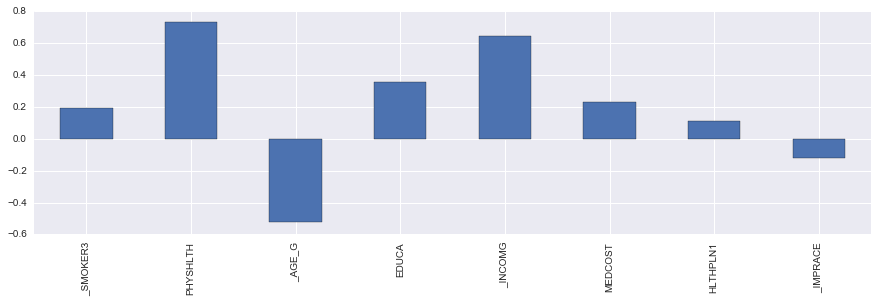

In [13]:
plt.figure(figsize=[15,4])

weights = pd.Series(logReg.coef_[0],index=df_logreg.columns)
weights.plot(kind='bar')
plt.show()

## Gradient Boosting Regression

We've identified the relative weighting of the variables and their impact on self-reported health quality, but what if we could narrow it down from 9 variables to one? We'll pursue gradient boosting regression to understand if one of the variables could serve as a proxy for all others.

In looking at the graphic above, it looks like the amount of exercise someone gets has the biggest impact on quality of health. So we’ll select that as the explanatory variable and keep self-reported health quality as our response variable. We’ll set the number of regression trees to 500, the depth of each individual tree to 4 the loss function to least squares and the learning rate to .01. The resulting mean squared error is .0859, which indicates a lack of fit between self-reported health quality and physical health. It would appear as though we need more variables in the model. 

MSE: 0.0859


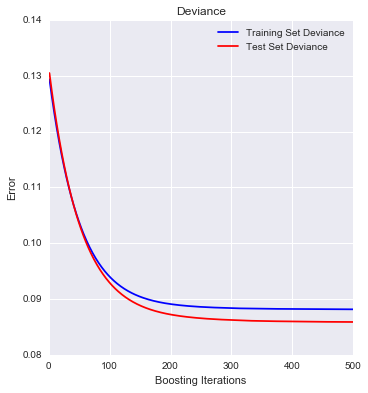

In [21]:
# code built from: 
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#example-ensemble-plot-gradient-boosting-regression-py

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

###############################################################################
# Load data
X, y = shuffle(df_reduced1.PHYSHLTH.reshape(-1,1), df_reduced1.health.ravel(), random_state=13)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

###############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Error')

### Interpreting the Chart Above

The chart above shows a very small difference between our training and test data set, which is a good thing, but the very low MSE means a lack of fit between the variables and an overall weak predictive model.


---
# K-Nearest Neighbors
---

In this section, will do an prediction analysis based on k-nearest neighbors (KNN).
This should give us clusters based on how well each point clusters on others.

We will use 10-fold cross validation, and 10 nearest neighbors. For the neighbors, 10 is an arbitrary value, chosed because we have a really big dataset.  ** WE SHOULD VARY THIS TO SEE WHAT DIFFERENCE IT MAKES **
We also use 10-fold cross validation.

In [22]:
# initial setup
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold

knn = df_reduced  # Copy the dataset for this analysis.
knn.fillna(value=0)

# and setup our X and Y
if '_Health' in knn:
    y = knn['_Health'].values # get the labels we want
    del knn['_Health'] # get rid of the class label

yhat = np.zeros(y.shape)  #empty array to fill with predictions m
X = knn.values

# Display the arrays.  Not really needed, but tells us that there are some nan values, which break things.
X, y

(array([[  1.,   3.,  88., ...,   2.,   1.,   1.],
        [  1.,   3.,   2., ...,   2.,   1.,   1.],
        [  1.,   4.,   3., ...,   2.,   1.,   1.],
        ..., 
        [  0.,   3.,  20., ...,   2.,   1.,   5.],
        [  1.,   4.,  88., ...,   2.,   1.,   5.],
        [  1.,   4.,  88., ...,   2.,   1.,   5.]]),
 array([ 1.,  1.,  1., ...,  0.,  1.,  1.]))

In [24]:
# data Cleanup. In conversion to numpy array from pandas
# some values are being converted to nan or inf values.
X=np.nan_to_num(X)

In [ ]:
#fit the KNN model to our data
cv = StratifiedKFold(y, n_folds=10)

# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors=10)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print 'KNN accuracy', total_accuracy
 

In [ ]:
# intentionally left blank

---
# Pipeline with PCA and KNN
---

Wow, the KNN got 87.7% accuracy. That's really good. But is it accurate? Now trying a pipeline doing a PCA first, then the KNN again. (Again, with k=10.)
Expect it will get even better, since PCA should eliminate whats no good. However, at this point we need to watch for overfitting. if our accuracy jumps real high, we should be suspicious.

In [ ]:
from sklearn.decomposition import RandomizedPCA 
from sklearn.pipeline import Pipeline

# setup pipeline to take PCA, then fit a KNN classifier
clf_pipe = Pipeline(
    [('PCA',RandomizedPCA(n_components=300)),
     ('CLF',KNeighborsClassifier(n_neighbors=10))]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print 'KNN, pipeline accuracy', total_accuracy

It's the same.  That's cool, since it's still using KNN.
Let's try something else...

---
# Random Forest Classifier
--- 
Since two different versions of KNN came out the same, lets compare it to something else.  We'll try random forest in our pipeline.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_pipe = Pipeline(
    [('PCA',RandomizedPCA(n_components=100)),
     ('CLF',RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1))]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print 'Pipeline accuracy %0.2f (+/- %0.2f)' % total_accuracy % (total_accuracy.std()*2)


This is very suspicious because it's so high. Seems likely we are overfitted.

### Deployment

For individuals, the model helps to clarify the relationship between self-reported health quality and a number of demographics and behaviors. The demographics are obviously beyond a person’s control, but the behaviors are not. The model shows that education level has the strongest correlation to good or better self-reported health quality, which we didn’t anticipate. Even if we can’t go so far as to interpret a cause and effect relationship, it appears as though those with more education self-report higher health quality. 

For policy makers, there is a constant competition for available public funds. If the case can be made that education not only helps a person to be more successful in their life, but also has a strong correlation to health quality, it could better make the case for increased investment. 

Many of these variables change over time and since the survey is conducted on an annual basis, it would be important to update the model each year and observe any changes between the relative weighting of the variables in the model. 

If the intent of the survey, the instrument where all this data came from, was to predict health quality, the surveyors could theoretically shorten the survey from 200+ variables to these key 9 and achieve similar results, at a much lower cost. 